# Training a Bayesian Neural Network for Computer Model Emulation

In [203]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [204]:
# suppress some theano compilation errors with MacOSX clang compiler
import theano
# CF added (https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T

In [205]:
#prepare the directories for model design and outputs
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [206]:
from calculations_load import *
from configurations import *

system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#X = design # include all parameters
X = design['norm'].values.reshape(-1, 1) #choose specific params=

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)
obs = 'dNch_deta' #choose the observable we want to emulate
cent_bin = 5 # choose the centrality bin 
Y = []
for pt in range(npt):
    Y.append( trimmed_model_data[system_str][pt, idf][obs]['mean'][cent_bin] )

Y = np.array(Y).reshape(-1, 1)
#Y = np.array(Y)

## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [251]:
X = X.astype(floatX)
Y = Y.astype(floatX)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1)

X_scaler = StandardScaler().fit(X_train)
Y_scaler = StandardScaler().fit(Y_train)

#X_scaler = MinMaxScaler().fit(X_train)
#Y_scaler = MinMaxScaler().fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train).reshape(Y_train.shape[0])
Y_test_sc = Y_scaler.transform(Y_test).reshape(Y_test.shape[0])

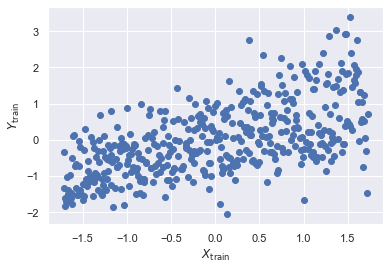

In [259]:
plt.scatter(X_train_sc, Y_train_sc)
plt.xlabel(r"$X_{\rm train}$")
plt.ylabel(r"$Y_{\rm train}$")
plt.show()

### The cell below constructs the neural net

In [254]:
sigma = 10

def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
    # Initialize random biases in each layer
    init_b_1 = np.random.randn(n_hidden).astype(floatX)
    init_b_2 = np.random.randn(n_hidden).astype(floatX)
    init_b_out = np.random.randn(1).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train_sc)
        ann_output = pm.Data('ann_output', Y_train_sc)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', mu=0, sigma=sigma, shape=(X.shape[1], n_hidden), testval=init_1)
        # Bias at 1st hidden layer
        bias_1 = pm.Normal('b_1', mu=0, sigma=sigma, shape=(n_hidden), testval=init_b_1)

        # Weights from 1st hidden to 2nd hidden layer
        weights_1_2 = pm.Normal('w_1_2', mu=0, sigma=sigma, shape=(n_hidden, n_hidden), testval=init_2)
        # Bias at 2nd hidden layer
        bias_2 = pm.Normal('b_2', mu=0, sigma=sigma, shape=(n_hidden), testval=init_b_2)
        
        # Weights from 2nd hidden layer to output
        weights_2_out = pm.Normal('w_2_out', mu=0, sigma=sigma, shape=(n_hidden,), testval=init_out)
        # Bias at output hidden layer
        bias_out = pm.Normal('b_out', mu=0, sigma=sigma, shape=(1), testval=init_b_out)

        # Build neural-network using tanh activation function
        #act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + bias_1)
        #act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + bias_2)
        #act_out = pm.math.dot(act_2, weights_2_out) + bias_out
        
        act_1 = pm.math.dot(ann_input, weights_in_1) + bias_1
        act_2 = pm.math.dot(act_1, weights_1_2) + bias_2
        act_out = pm.math.dot(act_2, weights_2_out) + bias_out
        
        #sd = pm.HalfNormal('sd', sigma=1)
        out = pm.Normal('out', mu=act_out, sigma=0.01, observed=ann_output)
        
    return neural_network

neural_network = construct_nn(X_train_sc, Y_train_sc)

In [255]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

### The cell below uses ADVI to train the network weights

In [256]:
%%time

with neural_network:
    inference = pm.ADVI()
    method = 'fullrank_advi'
    #inference = pm.FullRandADVI
    approx = pm.fit(n=100000, method=inference)

Average Loss = 1.3737e+06: 100%|██████████| 100000/100000 [06:23<00:00, 260.69it/s]
Finished [100%]: Average Loss = 1.3737e+06


CPU times: user 2min 36s, sys: 21.7 s, total: 2min 57s
Wall time: 6min 29s


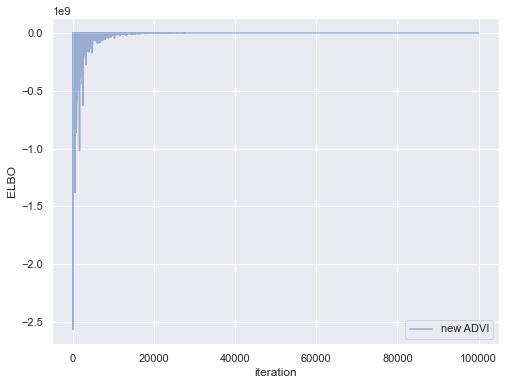

In [257]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(-inference.hist, label='new ADVI', alpha=.5)
ax.legend()
ax.set_ylabel('ELBO')
ax.set_xlabel('iteration')
plt.tight_layout;

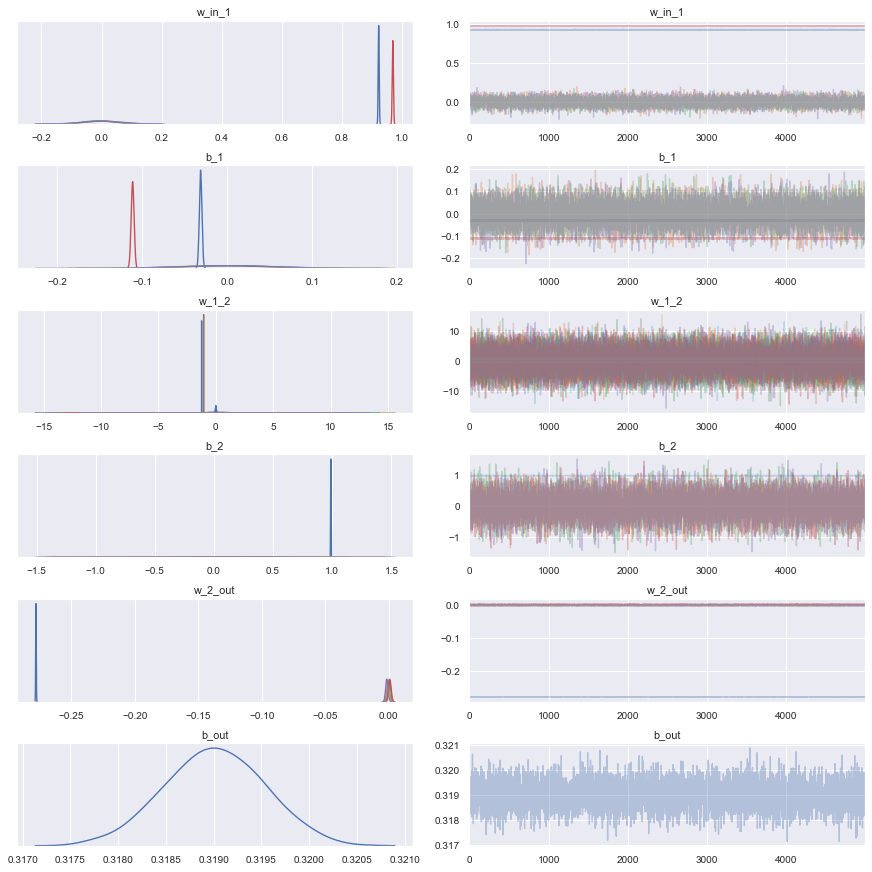

In [258]:
trace = approx.sample(draws=5000)
pm.traceplot(trace)
plt.show()

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). 
1. We can use `sample_posterior_predictive() <../api/inference.rst>`__ to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
1. It is better to get the node directly and build theano graph using our approximation (approx.sample_node) , we get a lot of speed up

In [260]:
# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train_sc[:10])
n.tag.test_value = 100
_sample_pred = approx.sample_node(neural_network.out.distribution.mu,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_pred = theano.function([x, n], _sample_pred)

# Create bechmark functions
def production_step1():
    pm.set_data(new_data={'ann_input': X_test_sc, 'ann_output': Y_test_sc}, model=neural_network)
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

    # make pred
    pred = ppc['out'].mean(axis=0)

def production_step2():
    sample_pred(X_test_sc, 500).mean(0) 

In [261]:
%timeit production_step1()

10.9 s ± 1.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [262]:
%timeit production_step2()

14.8 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let’s go ahead and generate predictions:

In [267]:
pred = sample_pred(X_train_sc, 500).mean(0)

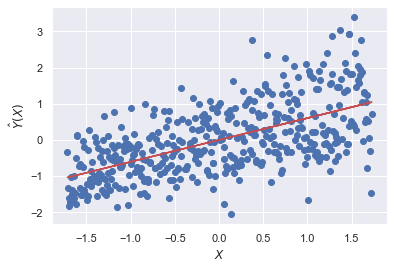

In [268]:
plt.plot(X_train_sc, pred, label='pred', color='r')
plt.scatter(X_train_sc, Y_train_sc, label='true')
plt.xlabel(r"$X$")
plt.ylabel(r"$\hat{Y}(X)$")
plt.show()

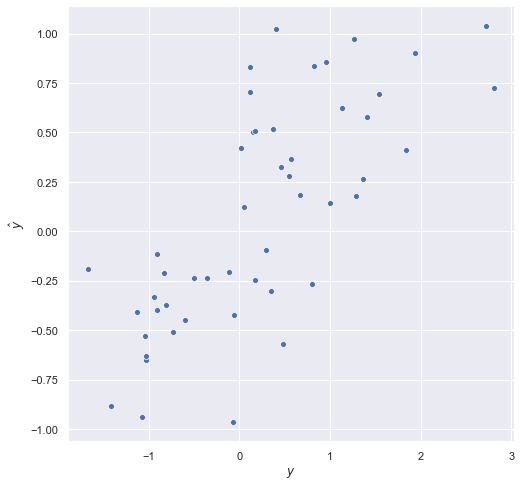

In [265]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(Y_test_sc, pred)
plt.xlabel(r"$y$")
plt.ylabel(r"$\hat{y}$")
plt.show()

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [ ]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ppc = sample_proba(grid_2d ,500)

### Probability surface

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

It is also clear that the uncertainty is large in the region where there is no training data. That is what should be expected, and it is good that our network shows this explicitly. The normal neural network would not give any such signals.

## Mini-batch ADVI

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [ ]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(-inference.hist)
ax.set_ylabel('ELBO')
ax.set_xlabel('iteration');

As you can see, mini-batch ADVI's running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

The plotting of traces in pyMC3 requires the ArviZ module.

In [ ]:
# NOTE: This takes too long or hangs up.
#pm.traceplot(trace);


## Next steps

[`Theano`](http://deeplearning.net/software/theano/), which is used by `PyMC3` as its computational backend, was mainly developed for estimating neural networks and there are great libraries like [`Lasagne`](https://github.com/Lasagne/Lasagne) that build on top of `Theano` to make construction of the most common neural network architectures easy. There is a [follow-up blog post on how to use Lasagne together with PyMC3](https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/).

You should be able to run this example on the GPU by setting `device = gpu` and `floatX = float32` in your `.theanorc`.

You might argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets, as demonstrated [here]([follow-up blog post on how to use Lasagne together with PyMC3](https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/).

## Acknowledgements

This notebook is very much inspired by a blog post written by Thomas Wiecki (and updated by Maxim Kochurov). The
original posts are available [here](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) and [here](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html).

This example uses the [PyMC3](https://docs.pymc.io/) package for probabilistic programming, and relies in particular on the [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi) implementation by [Taku Yoshioka](https://github.com/taku-y).